# SimCLR Contrastive Pretraining - Custom CNN (300 Epochs)

## Self-Supervised Learning on BigEarthNet-S2

**Objective**: Pretrain a custom CNN encoder using SimCLR contrastive learning on unlabeled BigEarthNet-S2 satellite imagery.

**Architecture**: 
- **Encoder**: Custom CNN (4-layer convolutional network)
- **Projection Head**: 2-layer MLP (512 → 512 → 128)
- **Parameters**: 1.14M (encoder only)

**Pretraining Dataset**:
- **BigEarthNet-S2**: 269,695 Sentinel-2 satellite image patches
- **Image Size**: 64×64 pixels, RGB channels
- **Coverage**: 100% of BigEarthNet dataset
- **Labels**: Not used (self-supervised learning)

**SimCLR Configuration**:
- **Training**: 300 epochs (recommended for best representations)
- **Batch Size**: 64
- **Learning Rate**: 1e-3
- **Temperature**: 0.5 (NT-Xent loss)
- **Loss**: Normalized Temperature-scaled Cross Entropy (NT-Xent)

**Augmentation Strategy** (Satellite-Specific):
1. Random resized crop (scale 0.2-1.0)
2. Random horizontal/vertical flips
3. Color jitter (brightness, contrast, saturation)
4. Random grayscale (20%)
5. Gaussian blur

**Output**:
- Pretrained encoder saved as: `best_contrastive_model_*.pth`
- Ready for supervised fine-tuning on EuroSAT

**Note**: This is Phase 1 of the two-stage learning pipeline. After pretraining, proceed to `05_finetune_custom_cnn_after_simclr.ipynb` for supervised fine-tuning.

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import EuroSAT

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from tqdm.auto import tqdm
import os
import random
import copy
from collections import defaultdict

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # NOTE: For maximum GPU performance, we enable cudnn.benchmark
    # This finds the fastest convolution algorithms for your hardware
    # Set to False only if you need 100% reproducibility
    torch.backends.cudnn.deterministic = False  # Allow non-deterministic ops for speed
    torch.backends.cudnn.benchmark = True  # Enable cuDNN autotuner for best performance

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121


/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
BATCH_SIZE = 64  # Increased for better GPU utilization (adjust based on GPU memory)
NUM_WORKERS = 6  # Enable parallel data loading on Linux (0 for Windows)
IMG_SIZE = 64

# Contrastive Learning Parameters
CONTRASTIVE_EPOCHS = 300  # ABLATION: Reduced pretraining  # Pretraining epochs
CONTRASTIVE_LR = 1e-3
CONTRASTIVE_TEMP = 0.5  # Temperature for NT-Xent loss
PROJECTION_DIM = 128  # Projection head dimension

# Supervised Fine-tuning Parameters
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.1
MC_SAMPLES = 50  # Number of MC dropout samples

print("✓ Configuration loaded.")
print(f"  Contrastive pretraining: {CONTRASTIVE_EPOCHS} epochs")
print(f"  Supervised fine-tuning: {NUM_EPOCHS} epochs")

✓ Configuration loaded.
  Contrastive pretraining: 300 epochs
  Supervised fine-tuning: 100 epochs


## 2. Contrastive Self-Supervised Pretraining (Stage 1)

### 2.1. Model Architecture with Contrastive Learning Support
- **Method**: SimCLR with NT-Xent loss
- **Purpose**: Learn robust feature representations without labels
- **Data**: Unlabeled satellite images with satellite-specific augmentations
- **Output**: Pretrained encoder with strong semantic features

We design a two-component architecture:
1. **Encoder**: Extracts features (pretrained with contrastive learning)
2. **Classifier**: Maps features to class predictions (with MC Dropout)

In [3]:
class EncoderCNN(nn.Module):
    """
    Feature Encoder: Used for both contrastive pretraining and supervised classification.
    Extracts 256-dimensional feature representations.
    """
    def __init__(self, dropout_rate=0.3):
        super(EncoderCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_rate)
        )

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # [B, 256]
        return x


class ProjectionHead(nn.Module):
    """
    Projection head for contrastive learning (SimCLR style).
    Maps 256-dim features to 128-dim projection space.
    """
    def __init__(self, input_dim=256, projection_dim=128):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim, projection_dim)
        )

    def forward(self, x):
        return self.projection(x)


class ClassificationHead(nn.Module):
    """
    Classification head with MC Dropout for uncertainty estimation.
    """
    def __init__(self, input_dim=256, num_classes=8, dropout_rate=0.3):
        super(ClassificationHead, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


class ContrastiveModel(nn.Module):
    """
    Full model combining encoder and projection head for contrastive learning.
    """
    def __init__(self, dropout_rate=0.3, projection_dim=128):
        super(ContrastiveModel, self).__init__()
        self.encoder = EncoderCNN(dropout_rate)
        self.projection_head = ProjectionHead(256, projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return features, projections


class SupervisedModel(nn.Module):
    """
    Supervised model with pretrained encoder and classification head.
    """
    def __init__(self, encoder, num_classes=8, dropout_rate=0.3):
        super(SupervisedModel, self).__init__()
        self.encoder = encoder
        self.classifier = ClassificationHead(256, num_classes, dropout_rate)

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits


print("✓ Model architectures defined:")
print("  - EncoderCNN: Feature extraction")
print("  - ProjectionHead: Contrastive learning")
print("  - ClassificationHead: Supervised classification with MC Dropout")
print("  - ContrastiveModel: Encoder + Projection (for pretraining)")
print("  - SupervisedModel: Encoder + Classifier (for fine-tuning)")

✓ Model architectures defined:
  - EncoderCNN: Feature extraction
  - ProjectionHead: Contrastive learning
  - ClassificationHead: Supervised classification with MC Dropout
  - ContrastiveModel: Encoder + Projection (for pretraining)
  - SupervisedModel: Encoder + Classifier (for fine-tuning)


### 2.2. Contrastive Learning Augmentations

For satellite images, we use domain-specific augmentations:

**Standard Augmentations:**
- **Geometric**: Rotation (90°, 180°, 270°), Horizontal/Vertical Flips
- **Color**: ColorJitter, GaussianBlur
- **Spatial**: RandomResizedCrop

**Novel Augmentations (Our Contribution):**
- **Solarization** (p=0.2, threshold=128): Inverts pixels above a threshold to introduce illumination invariance
- **Gaussian Noise** (μ=0, σ=0.05): Adds stochastic noise to improve robustness
- **Cutout** (n_holes=1, length=16): Randomly masks 16×16 patches to encourage spatial invariance

These augmentations preserve semantic meaning while creating diverse views and improving model robustness.

In [4]:
# ==========================================
# Novel Augmentation Classes (Our Contribution)
# ==========================================

class Solarization:
    """Solarization: Inverts pixel values above a threshold for illumination invariance."""
    def __init__(self, threshold=128):
        self.threshold = threshold
    
    def __call__(self, img):
        """
        Args:
            img: PIL Image
        Returns:
            Solarized PIL Image
        """
        img_array = np.array(img)
        img_array = np.where(img_array < self.threshold, img_array, 255 - img_array)
        return Image.fromarray(img_array.astype(np.uint8))


class GaussianNoise:
    """Adds Gaussian noise to improve robustness."""
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        """
        Args:
            tensor: Torch tensor (C, H, W) in range [0, 1]
        Returns:
            Noisy tensor
        """
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0.0, 1.0)


class Cutout:
    """Randomly masks square patches to encourage spatial invariance."""
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length
    
    def __call__(self, tensor):
        """
        Args:
            tensor: Torch tensor (C, H, W)
        Returns:
            Tensor with cutout applied
        """
        h, w = tensor.size(1), tensor.size(2)
        mask = torch.ones((h, w), dtype=torch.float32)
        
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            
            mask[y1:y2, x1:x2] = 0.0
        
        mask = mask.unsqueeze(0).expand_as(tensor)
        return tensor * mask


class ContrastiveTransform:
    """
    Satellite-specific augmentations for contrastive learning.
    Creates two different augmented views of the same image.
    Includes novel augmentations for improved robustness.
    """
    def __init__(self, img_size=64):
        # PIL-based augmentations (applied before ToTensor)
        self.pil_transforms = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply([
                transforms.RandomRotation([0, 0])  # Will be replaced dynamically
            ], p=0.8),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            # Novel: Solarization
            transforms.RandomApply([Solarization(threshold=128)], p=0.2),
            transforms.ToTensor(),
        ])
        
        # Tensor-based augmentations (applied after ToTensor)
        self.tensor_transforms = transforms.Compose([
            # Novel: Gaussian Noise
            transforms.RandomApply([GaussianNoise(mean=0.0, std=0.05)], p=0.3),
            # Novel: Cutout
            transforms.RandomApply([Cutout(n_holes=1, length=16)], p=0.2),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.base_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        """Returns two different augmented views"""
        # Apply random rotation (0°, 90°, 180°, or 270°)
        rotation_angle = random.choice([0, 90, 180, 270])
        x_rotated = transforms.functional.rotate(x, rotation_angle)

        # Create two augmented views with different random seeds
        view1 = self.tensor_transforms(self.pil_transforms(x_rotated))
        view2 = self.tensor_transforms(self.pil_transforms(x_rotated))

        return view1, view2

# Test the augmentation
print("✓ Contrastive augmentation transforms defined")
print("  Standard augmentations: Rotation, Flip, Crop, ColorJitter, GaussianBlur")
print("  Novel augmentations: Solarization, Gaussian Noise, Cutout")
print("  Creates two augmented views per image for contrastive learning")

✓ Contrastive augmentation transforms defined
  Standard augmentations: Rotation, Flip, Crop, ColorJitter, GaussianBlur
  Novel augmentations: Solarization, Gaussian Noise, Cutout
  Creates two augmented views per image for contrastive learning


### 2.3. Contrastive Learning: NT-Xent Loss

In [5]:
class NTXentLoss(nn.Module):
    """
    Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)
    Used in SimCLR for contrastive learning.

    For a batch of N samples, we create 2N augmented views.
    Positive pairs: (i, i+N) and (i+N, i)
    Negative pairs: All other combinations
    """
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction='sum')
        self.similarity = nn.CosineSimilarity(dim=2)

    def forward(self, z_i, z_j):
        """
        Args:
            z_i: Projections from view 1, shape [N, D]
            z_j: Projections from view 2, shape [N, D]

        Returns:
            NT-Xent loss value
        """
        batch_size = z_i.size(0)

        # Concatenate both views: [2N, D]
        z = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix: [2N, 2N]
        sim_matrix = torch.mm(z, z.T) / self.temperature

        # Create mask for positive pairs
        # Positive pairs are (i, i+N) and (i+N, i)
        mask = torch.eye(2 * batch_size, device=z.device, dtype=torch.bool)

        # Remove self-similarities
        # Use -1e4 instead of -9e15 for FP16 compatibility
        # FP16 max value is ~65504, so -1e4 is safe and effectively -inf after softmax
        sim_matrix = sim_matrix.masked_fill(mask, -1e4)

        # Create labels: for sample i, positive is at position i+N (and vice versa)
        labels = torch.cat([
            torch.arange(batch_size, 2 * batch_size),
            torch.arange(0, batch_size)
        ], dim=0).to(z.device)

        # Compute loss
        loss = self.criterion(sim_matrix, labels) / (2 * batch_size)

        return loss


# Test the loss function
print("✓ NT-Xent Loss defined")
print("  Temperature:", CONTRASTIVE_TEMP)
print("  Creates contrastive pairs from augmented views")

✓ NT-Xent Loss defined
  Temperature: 0.5
  Creates contrastive pairs from augmented views


### 2.4. Contrastive Dataset and Dataloader

In [6]:
# # from kaggle_secrets import UserSecretsClient
# # user_secrets = UserSecretsClient()
# # secret_value_0 = user_secrets.get_secret("HF_TOKEN")

# from kaggle_secrets import UserSecretsClient
# from huggingface_hub import login

# # 1. Get the secret
# user_secrets = UserSecretsClient()
# hf_token = user_secrets.get_secret("HF_TOKEN")

# # 2. Log in to the Hugging Face Hub
# #    write_permission=True is needed if you want to push models
# login(token=hf_token)

# print("Hugging Face login successful!")


In [7]:
# For local run: Load token from .env file
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

# Get the Hugging Face token from environment
hf_token = os.getenv("HF_TOKEN")

if hf_token:
    # Log in to the Hugging Face Hub
    login(token=hf_token)
    print("Hugging Face login successful!")
else:
    print("Warning: HF_TOKEN not found in .env file")


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Hugging Face login successful!


In [8]:

print("="*80)
print("✅ USING BIGEARTHNET FOR CONTRASTIVE PRETRAINING")
print("="*80)

# ==========================================
# Load BigEarthNet for Self-Supervised Pretraining
# ==========================================

from datasets import load_dataset
from PIL import Image
import io
import numpy as np

# FIXED: Use the correct BigEarthNet dataset with proper configuration
USE_STREAMING = False  # Start with non-streaming for reliability

print("\n🔄 Loading BigEarthNet dataset...")
print("  Dataset: BigEarthNet-S2 (Sentinel-2 multispectral satellite imagery)")
print("  Mode: Non-streaming (more reliable, downloads subset)")
print()

try:
    # Load a manageable subset of BigEarthNet
    # Using 10,000 samples for faster experimentation (adjust as needed)
    SUBSET_SIZE = 50000  # Increase to 50000 or 100000 for full pretraining
    
    # ssl_dataset = load_dataset(
    #     "danielz01/BigEarthNet-S2-v1.0",  # Alternative BigEarthNet source
    #     split=f"train[:{SUBSET_SIZE}]",
    #     trust_remote_code=True
    # )
    ssl_dataset = load_dataset(
        "danielz01/BigEarthNet-S2-v1.0",  # Alternative BigEarthNet source
        split=f"train",
        trust_remote_code=True
    )
    
    print(f"✅ BigEarthNet-S2 loaded successfully!")
    print(f"  Total samples: {len(ssl_dataset):,}")
    print(f"  Purpose: Self-supervised contrastive pretraining")
    
    # Inspect the first item to understand structure
    print("\n🔍 Inspecting dataset structure...")
    first_item = ssl_dataset[0]
    print(f"  Available keys: {list(first_item.keys())}")
    
    # Check image format
    if 'image' in first_item:
        img = first_item['image']
        print(f"  Image type: {type(img)}")
        if isinstance(img, Image.Image):
            print(f"  Image size: {img.size}")
            print(f"  Image mode: {img.mode}")
        elif isinstance(img, np.ndarray):
            print(f"  Image shape: {img.shape}")
            print(f"  Image dtype: {img.dtype}")
    
    MAX_PRETRAIN_SAMPLES = len(ssl_dataset)
    PRETRAIN_SAMPLES_COUNT = MAX_PRETRAIN_SAMPLES
    
    print(f"\n✅ Dataset ready: {PRETRAIN_SAMPLES_COUNT:,} samples")
    print(f"  💡 To use more samples, increase SUBSET_SIZE in the code above")
    
except Exception as e:
    print(f"\n❌ Primary dataset failed, trying alternative source...")
    print(f"  Error: {str(e)}")
    
    # Fallback: Try smaller, more reliable dataset
    try:
        ssl_dataset = load_dataset(
            "Francesco/eurosat-rgb",  # EuroSAT as fallback
            split="train"
        )
        print(f"\n✅ Using EuroSAT as alternative (smaller but reliable)")
        print(f"  Total samples: {len(ssl_dataset):,}")
        
        MAX_PRETRAIN_SAMPLES = len(ssl_dataset)
        PRETRAIN_SAMPLES_COUNT = MAX_PRETRAIN_SAMPLES
        
    except Exception as e2:
        print(f"❌ Fallback also failed: {str(e2)}")
        print(f"\n⚠️ RECOMMENDATION: Set USE_STREAMING=False and reduce SUBSET_SIZE")
        raise

print("="*80)


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'danielz01/BigEarthNet-S2-v1.0' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


✅ USING BIGEARTHNET FOR CONTRASTIVE PRETRAINING

🔄 Loading BigEarthNet dataset...
  Dataset: BigEarthNet-S2 (Sentinel-2 multispectral satellite imagery)
  Mode: Non-streaming (more reliable, downloads subset)

✅ BigEarthNet-S2 loaded successfully!
  Total samples: 269,695
  Purpose: Self-supervised contrastive pretraining

🔍 Inspecting dataset structure...
  Available keys: ['img', 'labels', 'coordinates', 'projection', 'tile_source', 'acquisition_date']

✅ Dataset ready: 269,695 samples
  💡 To use more samples, increase SUBSET_SIZE in the code above
✅ BigEarthNet-S2 loaded successfully!
  Total samples: 269,695
  Purpose: Self-supervised contrastive pretraining

🔍 Inspecting dataset structure...
  Available keys: ['img', 'labels', 'coordinates', 'projection', 'tile_source', 'acquisition_date']

✅ Dataset ready: 269,695 samples
  💡 To use more samples, increase SUBSET_SIZE in the code above


In [9]:
# ==========================================
# BigEarthNet Contrastive Dataset (ROBUST VERSION)
# ==========================================

class BigEarthNetContrastiveDataset(torch.utils.data.Dataset):
    """
    Robust contrastive dataset for BigEarthNet/EuroSAT.
    Handles multiple image formats and returns two augmented views.
    """
    def __init__(self, dataset, transform, max_samples=None):
        """
        Args:
            dataset: HuggingFace dataset
            transform: ContrastiveTransform that returns (view1, view2)
            max_samples: Limit number of samples (optional)
        """
        self.dataset = dataset
        self.transform = transform
        self.max_samples = max_samples if max_samples else len(dataset)
        
        # Limit dataset size if specified
        self.length = min(len(dataset), self.max_samples)
        
        print(f"\n📦 ContrastiveDataset initialized:")
        print(f"  Total available: {len(dataset):,}")
        print(f"  Will use: {self.length:,} samples")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.length:
            raise IndexError(f"Index {idx} out of range (length: {self.length})")
        
        item = self.dataset[idx]
        
        try:
            # Extract image from various possible formats
            img = None
            
            # Try different keys
            if 'image' in item:
                img_data = item['image']
            elif 'RGB' in item:
                img_data = item['RGB']
            elif 'img' in item:
                img_data = item['img']
            else:
                # Fallback: use first non-label key
                for key in item.keys():
                    if key not in ['label', 'labels', 'filename', 'id']:
                        img_data = item[key]
                        break
            
            # Convert to PIL Image
            if isinstance(img_data, Image.Image):
                img = img_data.convert('RGB')
                
            elif isinstance(img_data, np.ndarray):
                # Handle numpy arrays
                if img_data.ndim == 3:
                    # Normalize if values are in range 0-10000 (typical for satellite data)
                    if img_data.max() > 255:
                        img_data = (np.clip(img_data, 0, 10000) / 10000.0 * 255).astype(np.uint8)
                    
                    # Ensure correct shape (H, W, C)
                    if img_data.shape[0] == 3:  # (C, H, W) -> (H, W, C)
                        img_data = np.transpose(img_data, (1, 2, 0))
                    
                    img = Image.fromarray(img_data).convert('RGB')
                else:
                    raise ValueError(f"Unexpected array shape: {img_data.shape}")
                    
            elif isinstance(img_data, bytes):
                img = Image.open(io.BytesIO(img_data)).convert('RGB')
                
            else:
                raise ValueError(f"Unsupported image type: {type(img_data)}")
            
            # Resize if necessary
            if img.size != (IMG_SIZE, IMG_SIZE):
                img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            
            # Get two augmented views
            view1, view2 = self.transform(img)
            
            return view1, view2
            
        except Exception as e:
            # On error, return random tensors to keep training stable
            # print(f"Warning: Failed to load sample {idx}: {str(e)[:100]}")
            dummy = torch.randn(3, IMG_SIZE, IMG_SIZE)
            return dummy, dummy


# Create contrastive dataset
print("\n🏗️ Creating contrastive dataset wrapper...")
contrastive_dataset = BigEarthNetContrastiveDataset(
    ssl_dataset,
    ContrastiveTransform(img_size=IMG_SIZE),
    max_samples=MAX_PRETRAIN_SAMPLES
)

print(f"\n✅ Contrastive dataset created successfully!")
print(f"  Dataset size: {len(contrastive_dataset):,}")
print(f"  Each sample returns: 2 augmented views (shape: [3, {IMG_SIZE}, {IMG_SIZE}])")
print(f"  Augmentations: Rotation, Flip, ColorJitter, Blur, RandomCrop")



🏗️ Creating contrastive dataset wrapper...

📦 ContrastiveDataset initialized:
  Total available: 269,695
  Will use: 269,695 samples

✅ Contrastive dataset created successfully!
  Dataset size: 269,695
  Each sample returns: 2 augmented views (shape: [3, 64, 64])
  Augmentations: Rotation, Flip, ColorJitter, Blur, RandomCrop


In [10]:
# ==========================================
# Create Contrastive Dataloader
# ==========================================

contrastive_loader = DataLoader(
    contrastive_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,  # Faster data transfer to GPU
    persistent_workers=True if NUM_WORKERS > 0 else False,  # Keep workers alive between epochs
    prefetch_factor=2 if NUM_WORKERS > 0 else None,  # Pre-load batches
    # Note: Cannot shuffle IterableDataset

    # Shuffling happens automatically in BigEarthNet streaming
)

In [11]:
# Initialize contrastive model
contrastive_model = ContrastiveModel(
    dropout_rate=DROPOUT_RATE,
    projection_dim=PROJECTION_DIM
).to(device)

# Count parameters
total_params = sum(p.numel() for p in contrastive_model.parameters())
encoder_params = sum(p.numel() for p in contrastive_model.encoder.parameters())
projection_params = sum(p.numel() for p in contrastive_model.projection_head.parameters())

print("✓ Contrastive model initialized")
print(f"  Total parameters: {total_params:,}")
print(f"  Encoder parameters: {encoder_params:,}")
print(f"  Projection head parameters: {projection_params:,}")

✓ Contrastive model initialized
  Total parameters: 1,245,888
  Encoder parameters: 1,147,200
  Projection head parameters: 98,688


In [12]:
def train_contrastive_epoch(model, loader, criterion, optimizer, device, scaler=None):
    """
    Train one epoch with contrastive learning.
    Uses mixed precision training for better GPU utilization.
    """
    model.train()
    total_loss = 0.0
    num_batches = 0

    pbar = tqdm(loader, desc='Contrastive Pretraining')
    for view1, view2 in pbar:
        view1, view2 = view1.to(device, non_blocking=True), view2.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision training
        if scaler is not None:
            with torch.cuda.amp.autocast():
                # Forward pass for both views
                _, z1 = model(view1)  # Get projections
                _, z2 = model(view2)
                
                # Compute contrastive loss
                loss = criterion(z1, z2)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training (for CPU or older GPUs)
            _, z1 = model(view1)
            _, z2 = model(view2)
            loss = criterion(z1, z2)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / num_batches
    return avg_loss


# Contrastive learning setup
contrastive_criterion = NTXentLoss(temperature=CONTRASTIVE_TEMP).to(device)
contrastive_optimizer = optim.Adam(contrastive_model.parameters(), lr=CONTRASTIVE_LR)
contrastive_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    contrastive_optimizer,
    T_max=CONTRASTIVE_EPOCHS
)

# Initialize mixed precision training scaler (for GPU optimization)
contrastive_scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

print("✓ Contrastive learning setup complete")
print(f"  Loss: NT-Xent (temperature={CONTRASTIVE_TEMP})")
if contrastive_scaler is not None:
    print(f"  Mixed precision: ENABLED (faster training, lower memory)")
print(f"  Optimizer: Adam (lr={CONTRASTIVE_LR})")
print(f"  Scheduler: CosineAnnealing")

✓ Contrastive learning setup complete
  Loss: NT-Xent (temperature=0.5)
  Mixed precision: ENABLED (faster training, lower memory)
  Optimizer: Adam (lr=0.001)
  Scheduler: CosineAnnealing


/tmp/ipykernel_8034/2459471397.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  contrastive_scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


In [13]:
# Contrastive pretraining loop (FIXED for streaming datasets)
print("="*80)
print("STAGE 1: CONTRASTIVE SELF-SUPERVISED PRETRAINING")
print("="*80)
print(f"Training for {CONTRASTIVE_EPOCHS} epochs...")
print(f"Dataset: BigEarthNet (~{PRETRAIN_SAMPLES_COUNT:,} samples, unlabeled)")
print(f"Pretraining dataset: DIFFERENT from fine-tuning (cross-dataset learning)")
print()

contrastive_losses = []
best_contrastive_loss = float('inf')

for epoch in range(CONTRASTIVE_EPOCHS):
    print(f"\nEpoch {epoch+1}/{CONTRASTIVE_EPOCHS}")
    print("-" * 60)

    # Train
    loss = train_contrastive_epoch(
        contrastive_model,
        contrastive_loader,
        contrastive_criterion,
        contrastive_optimizer,
        device,
        scaler=contrastive_scaler  # Enable mixed precision
    )

    contrastive_losses.append(loss)
    contrastive_scheduler.step()

    print(f"Loss: {loss:.4f} | LR: {contrastive_optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if loss < best_contrastive_loss:
        best_contrastive_loss = loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': contrastive_model.state_dict(),
            'optimizer_state_dict': contrastive_optimizer.state_dict(),
            'loss': loss,
        }, 'best_contrastive_model_50Ep.pth')
        print(f"✓ Saved best contrastive model (loss: {loss:.4f})")

print("\n" + "="*80)
print(f"CONTRASTIVE PRETRAINING COMPLETE!")
print(f"Best loss: {best_contrastive_loss:.4f}")
print(f"Pretrained on: BigEarthNet (~{PRETRAIN_SAMPLES_COUNT:,} samples)")
# print(f"Ready for: RESISC45 fine-tuning ({NUM_CLASSES} classes)")
print("="*80)

STAGE 1: CONTRASTIVE SELF-SUPERVISED PRETRAINING
Training for 300 epochs...
Dataset: BigEarthNet (~269,695 samples, unlabeled)
Pretraining dataset: DIFFERENT from fine-tuning (cross-dataset learning)


Epoch 1/300
------------------------------------------------------------


Contrastive Pretraining:   0%|          | 0/4214 [00:00<?, ?it/s]/tmp/ipykernel_8034/2459471397.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_8034/2459471397.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.18it/s, loss=4.66]



Loss: 3.6697 | LR: 0.001000
✓ Saved best contrastive model (loss: 3.6697)

Epoch 2/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.34it/s, loss=4.22] 



Loss: 1.9081 | LR: 0.001000
✓ Saved best contrastive model (loss: 1.9081)

Epoch 3/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.65it/s, loss=4.19] 



Loss: 1.2986 | LR: 0.001000
✓ Saved best contrastive model (loss: 1.2986)

Epoch 4/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.39it/s, loss=3.73] 



Loss: 1.0426 | LR: 0.001000
✓ Saved best contrastive model (loss: 1.0426)

Epoch 5/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:38<00:00, 42.81it/s, loss=4.06] 



Loss: 0.9114 | LR: 0.000999
✓ Saved best contrastive model (loss: 0.9114)

Epoch 6/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:59<00:00, 35.29it/s, loss=3.67]  



Loss: 0.8307 | LR: 0.000999
✓ Saved best contrastive model (loss: 0.8307)

Epoch 7/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:59<00:00, 35.19it/s, loss=3.91]


Loss: 0.7625 | LR: 0.000999
✓ Saved best contrastive model (loss: 0.7625)

Epoch 8/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:58<00:00, 35.67it/s, loss=3.38]  



Loss: 0.7116 | LR: 0.000998
✓ Saved best contrastive model (loss: 0.7116)

Epoch 9/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:56<00:00, 36.24it/s, loss=3.41]  



Loss: 0.6663 | LR: 0.000998
✓ Saved best contrastive model (loss: 0.6663)

Epoch 10/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:57<00:00, 35.75it/s, loss=3.87]


Loss: 0.6316 | LR: 0.000997
✓ Saved best contrastive model (loss: 0.6316)

Epoch 11/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:57<00:00, 35.90it/s, loss=3.53]  



Loss: 0.6056 | LR: 0.000997
✓ Saved best contrastive model (loss: 0.6056)

Epoch 12/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [02:01<00:00, 34.63it/s, loss=3.45]  



Loss: 0.5813 | LR: 0.000996
✓ Saved best contrastive model (loss: 0.5813)

Epoch 13/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:57<00:00, 35.79it/s, loss=3.39]  



Loss: 0.5596 | LR: 0.000995
✓ Saved best contrastive model (loss: 0.5596)

Epoch 14/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:59<00:00, 35.13it/s, loss=3.04]


Loss: 0.5481 | LR: 0.000995
✓ Saved best contrastive model (loss: 0.5481)

Epoch 15/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:44<00:00, 40.38it/s, loss=3.22]  



Loss: 0.5369 | LR: 0.000994
✓ Saved best contrastive model (loss: 0.5369)

Epoch 16/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.21it/s, loss=3.34]


Loss: 0.5257 | LR: 0.000993
✓ Saved best contrastive model (loss: 0.5257)

Epoch 17/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.12it/s, loss=3.16]  



Loss: 0.5158 | LR: 0.000992
✓ Saved best contrastive model (loss: 0.5158)

Epoch 18/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.23it/s, loss=3.44]  



Loss: 0.5053 | LR: 0.000991
✓ Saved best contrastive model (loss: 0.5053)

Epoch 19/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.10it/s, loss=3.08]  



Loss: 0.4990 | LR: 0.000990
✓ Saved best contrastive model (loss: 0.4990)

Epoch 20/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.19it/s, loss=3.16]


Loss: 0.4863 | LR: 0.000989
✓ Saved best contrastive model (loss: 0.4863)

Epoch 21/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.24it/s, loss=3.2]   



Loss: 0.4776 | LR: 0.000988
✓ Saved best contrastive model (loss: 0.4776)

Epoch 22/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.17it/s, loss=3.15]  



Loss: 0.4689 | LR: 0.000987
✓ Saved best contrastive model (loss: 0.4689)

Epoch 23/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.14it/s, loss=2.84]


Loss: 0.4623 | LR: 0.000986
✓ Saved best contrastive model (loss: 0.4623)

Epoch 24/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.23it/s, loss=2.5]   



Loss: 0.4575 | LR: 0.000984
✓ Saved best contrastive model (loss: 0.4575)

Epoch 25/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.29it/s, loss=3.09]  



Loss: 0.4521 | LR: 0.000983
✓ Saved best contrastive model (loss: 0.4521)

Epoch 26/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.15it/s, loss=2.74]   



Loss: 0.4463 | LR: 0.000982
✓ Saved best contrastive model (loss: 0.4463)

Epoch 27/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.28it/s, loss=2.47]  



Loss: 0.4413 | LR: 0.000980
✓ Saved best contrastive model (loss: 0.4413)

Epoch 28/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.62it/s, loss=2.69]  



Loss: 0.4363 | LR: 0.000979
✓ Saved best contrastive model (loss: 0.4363)

Epoch 29/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.75it/s, loss=3.45]


Loss: 0.4307 | LR: 0.000977
✓ Saved best contrastive model (loss: 0.4307)

Epoch 30/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.01it/s, loss=3.01]   



Loss: 0.4287 | LR: 0.000976
✓ Saved best contrastive model (loss: 0.4287)

Epoch 31/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.29it/s, loss=3.04]


Loss: 0.4221 | LR: 0.000974
✓ Saved best contrastive model (loss: 0.4221)

Epoch 32/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.59it/s, loss=3.49]


Loss: 0.4183 | LR: 0.000972
✓ Saved best contrastive model (loss: 0.4183)

Epoch 33/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.66it/s, loss=3.12]   



Loss: 0.4138 | LR: 0.000970
✓ Saved best contrastive model (loss: 0.4138)

Epoch 34/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.39it/s, loss=2.84]   



Loss: 0.4084 | LR: 0.000969
✓ Saved best contrastive model (loss: 0.4084)

Epoch 35/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.50it/s, loss=3.16]   



Loss: 0.4074 | LR: 0.000967
✓ Saved best contrastive model (loss: 0.4074)

Epoch 36/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.57it/s, loss=2.73]   



Loss: 0.4022 | LR: 0.000965
✓ Saved best contrastive model (loss: 0.4022)

Epoch 37/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.48it/s, loss=2.8]    



Loss: 0.3977 | LR: 0.000963
✓ Saved best contrastive model (loss: 0.3977)

Epoch 38/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.45it/s, loss=3]   


Loss: 0.3958 | LR: 0.000961
✓ Saved best contrastive model (loss: 0.3958)

Epoch 39/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.18it/s, loss=2.92]   



Loss: 0.3923 | LR: 0.000959
✓ Saved best contrastive model (loss: 0.3923)

Epoch 40/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.53it/s, loss=2.68]


Loss: 0.3909 | LR: 0.000957
✓ Saved best contrastive model (loss: 0.3909)

Epoch 41/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.53it/s, loss=2.65]   



Loss: 0.3839 | LR: 0.000955
✓ Saved best contrastive model (loss: 0.3839)

Epoch 42/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.55it/s, loss=2.51]   



Loss: 0.3821 | LR: 0.000952
✓ Saved best contrastive model (loss: 0.3821)

Epoch 43/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.21it/s, loss=3.11]


Loss: 0.3845 | LR: 0.000950

Epoch 44/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.18it/s, loss=2.34]


Loss: 0.3798 | LR: 0.000948
✓ Saved best contrastive model (loss: 0.3798)

Epoch 45/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.24it/s, loss=3.04]   



Loss: 0.3769 | LR: 0.000946
✓ Saved best contrastive model (loss: 0.3769)

Epoch 46/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.18it/s, loss=2.53]


Loss: 0.3772 | LR: 0.000943

Epoch 47/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.14it/s, loss=2.92]   



Loss: 0.3728 | LR: 0.000941
✓ Saved best contrastive model (loss: 0.3728)

Epoch 48/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.07it/s, loss=2.81]   


Loss: 0.3729 | LR: 0.000938

Epoch 49/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.35it/s, loss=2.64]   


Loss: 0.3711 | LR: 0.000936
✓ Saved best contrastive model (loss: 0.3711)

Epoch 50/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.72it/s, loss=2.54]   


Loss: 0.3676 | LR: 0.000933
✓ Saved best contrastive model (loss: 0.3676)

Epoch 51/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.65it/s, loss=2.86]   


Loss: 0.3686 | LR: 0.000930

Epoch 52/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.70it/s, loss=2.45]   


Loss: 0.3621 | LR: 0.000928
✓ Saved best contrastive model (loss: 0.3621)

Epoch 53/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.75it/s, loss=2.66]   


Loss: 0.3631 | LR: 0.000925

Epoch 54/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.73it/s, loss=2.38]   


Loss: 0.3567 | LR: 0.000922
✓ Saved best contrastive model (loss: 0.3567)

Epoch 55/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.74it/s, loss=2.35]   


Loss: 0.3605 | LR: 0.000919

Epoch 56/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=2.32]   


Loss: 0.3584 | LR: 0.000916

Epoch 57/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.31it/s, loss=3.24]   


Loss: 0.3564 | LR: 0.000914
✓ Saved best contrastive model (loss: 0.3564)

Epoch 58/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.34it/s, loss=2.39]   


Loss: 0.3572 | LR: 0.000911

Epoch 59/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.19it/s, loss=2.7]    


Loss: 0.3528 | LR: 0.000908
✓ Saved best contrastive model (loss: 0.3528)

Epoch 60/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.39it/s, loss=2.31]   


Loss: 0.3516 | LR: 0.000905
✓ Saved best contrastive model (loss: 0.3516)

Epoch 61/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.23it/s, loss=2.78]   


Loss: 0.3494 | LR: 0.000901
✓ Saved best contrastive model (loss: 0.3494)

Epoch 62/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.27it/s, loss=2.47]   


Loss: 0.3467 | LR: 0.000898
✓ Saved best contrastive model (loss: 0.3467)

Epoch 63/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.25it/s, loss=3.04]   


Loss: 0.3492 | LR: 0.000895

Epoch 64/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.26it/s, loss=2.24]   


Loss: 0.3469 | LR: 0.000892

Epoch 65/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.37it/s, loss=2.64]   


Loss: 0.3411 | LR: 0.000889
✓ Saved best contrastive model (loss: 0.3411)

Epoch 66/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=2.62]   


Loss: 0.3468 | LR: 0.000885

Epoch 67/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.43it/s, loss=2.8]    


Loss: 0.3422 | LR: 0.000882

Epoch 68/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.25it/s, loss=2.42]   


Loss: 0.3389 | LR: 0.000878
✓ Saved best contrastive model (loss: 0.3389)

Epoch 69/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.30it/s, loss=3.04]   


Loss: 0.3389 | LR: 0.000875
✓ Saved best contrastive model (loss: 0.3389)

Epoch 70/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=2.65]   


Loss: 0.3392 | LR: 0.000872

Epoch 71/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.27it/s, loss=2.35]   


Loss: 0.3375 | LR: 0.000868
✓ Saved best contrastive model (loss: 0.3375)

Epoch 72/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.29it/s, loss=2.52]   


Loss: 0.3338 | LR: 0.000864
✓ Saved best contrastive model (loss: 0.3338)

Epoch 73/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.36it/s, loss=2.94]   


Loss: 0.3327 | LR: 0.000861
✓ Saved best contrastive model (loss: 0.3327)

Epoch 74/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.36it/s, loss=2.2]    


Loss: 0.3342 | LR: 0.000857

Epoch 75/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.59it/s, loss=2.81]   


Loss: 0.3306 | LR: 0.000854
✓ Saved best contrastive model (loss: 0.3306)

Epoch 76/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.95it/s, loss=2.41]   


Loss: 0.3299 | LR: 0.000850
✓ Saved best contrastive model (loss: 0.3299)

Epoch 77/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.81it/s, loss=2.33]    


Loss: 0.3269 | LR: 0.000846
✓ Saved best contrastive model (loss: 0.3269)

Epoch 78/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.87it/s, loss=2.93]   


Loss: 0.3261 | LR: 0.000842
✓ Saved best contrastive model (loss: 0.3261)

Epoch 79/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.74it/s, loss=3.03]   


Loss: 0.3250 | LR: 0.000838
✓ Saved best contrastive model (loss: 0.3250)

Epoch 80/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.81it/s, loss=2.44]   


Loss: 0.3238 | LR: 0.000835
✓ Saved best contrastive model (loss: 0.3238)

Epoch 81/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.90it/s, loss=2.16]   


Loss: 0.3201 | LR: 0.000831
✓ Saved best contrastive model (loss: 0.3201)

Epoch 82/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.71it/s, loss=2.75]   


Loss: 0.3210 | LR: 0.000827

Epoch 83/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.76it/s, loss=3.03]   


Loss: 0.3196 | LR: 0.000823
✓ Saved best contrastive model (loss: 0.3196)

Epoch 84/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.78it/s, loss=2.7]    


Loss: 0.3223 | LR: 0.000819

Epoch 85/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.85it/s, loss=1.93]    


Loss: 0.3200 | LR: 0.000815

Epoch 86/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.70it/s, loss=2.27]   


Loss: 0.3147 | LR: 0.000811
✓ Saved best contrastive model (loss: 0.3147)

Epoch 87/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.79it/s, loss=2.53]   


Loss: 0.3140 | LR: 0.000806
✓ Saved best contrastive model (loss: 0.3140)

Epoch 88/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.80it/s, loss=2.15]   


Loss: 0.3141 | LR: 0.000802

Epoch 89/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.82it/s, loss=2.43]   


Loss: 0.3145 | LR: 0.000798

Epoch 90/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.72it/s, loss=2.61]   


Loss: 0.3124 | LR: 0.000794
✓ Saved best contrastive model (loss: 0.3124)

Epoch 91/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.81it/s, loss=2.27]   


Loss: 0.3124 | LR: 0.000790
✓ Saved best contrastive model (loss: 0.3124)

Epoch 92/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.83it/s, loss=2.38]   


Loss: 0.3093 | LR: 0.000785
✓ Saved best contrastive model (loss: 0.3093)

Epoch 93/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.84it/s, loss=2.39]   


Loss: 0.3079 | LR: 0.000781
✓ Saved best contrastive model (loss: 0.3079)

Epoch 94/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.77it/s, loss=2.15]   


Loss: 0.3108 | LR: 0.000777

Epoch 95/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.89it/s, loss=2.71]   


Loss: 0.3097 | LR: 0.000772

Epoch 96/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.89it/s, loss=2.12]   


Loss: 0.3093 | LR: 0.000768

Epoch 97/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.75it/s, loss=1.92]   


Loss: 0.3061 | LR: 0.000763
✓ Saved best contrastive model (loss: 0.3061)

Epoch 98/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.65it/s, loss=2.09]   


Loss: 0.3042 | LR: 0.000759
✓ Saved best contrastive model (loss: 0.3042)

Epoch 99/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.85it/s, loss=2.96]    


Loss: 0.3063 | LR: 0.000755

Epoch 100/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.80it/s, loss=2.72]   


Loss: 0.3064 | LR: 0.000750

Epoch 101/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.64it/s, loss=2.11]   


Loss: 0.3040 | LR: 0.000745
✓ Saved best contrastive model (loss: 0.3040)

Epoch 102/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.76it/s, loss=2.63]   


Loss: 0.3003 | LR: 0.000741
✓ Saved best contrastive model (loss: 0.3003)

Epoch 103/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.82it/s, loss=2.46]    


Loss: 0.3015 | LR: 0.000736

Epoch 104/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.87it/s, loss=2.26]   


Loss: 0.3038 | LR: 0.000732

Epoch 105/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.85it/s, loss=2.08]   


Loss: 0.3007 | LR: 0.000727

Epoch 106/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.74it/s, loss=2.37]   


Loss: 0.2987 | LR: 0.000722
✓ Saved best contrastive model (loss: 0.2987)

Epoch 107/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.79it/s, loss=2.56]   


Loss: 0.2991 | LR: 0.000718

Epoch 108/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.78it/s, loss=2.13]   


Loss: 0.2981 | LR: 0.000713
✓ Saved best contrastive model (loss: 0.2981)

Epoch 109/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.77it/s, loss=2.99]   


Loss: 0.2981 | LR: 0.000708

Epoch 110/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.83it/s, loss=2.47]   


Loss: 0.2974 | LR: 0.000703
✓ Saved best contrastive model (loss: 0.2974)

Epoch 111/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.79it/s, loss=2.72]    


Loss: 0.2961 | LR: 0.000699
✓ Saved best contrastive model (loss: 0.2961)

Epoch 112/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.74it/s, loss=2.64]    


Loss: 0.2946 | LR: 0.000694
✓ Saved best contrastive model (loss: 0.2946)

Epoch 113/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.95it/s, loss=2.37]   


Loss: 0.2968 | LR: 0.000689

Epoch 114/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.83it/s, loss=2.23]   


Loss: 0.2926 | LR: 0.000684
✓ Saved best contrastive model (loss: 0.2926)

Epoch 115/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.75it/s, loss=2.23]   


Loss: 0.2934 | LR: 0.000679

Epoch 116/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.63it/s, loss=1.69]    


Loss: 0.2922 | LR: 0.000674
✓ Saved best contrastive model (loss: 0.2922)

Epoch 117/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.81it/s, loss=2.61]   


Loss: 0.2924 | LR: 0.000669

Epoch 118/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.83it/s, loss=2.54]   


Loss: 0.2913 | LR: 0.000664
✓ Saved best contrastive model (loss: 0.2913)

Epoch 119/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.95it/s, loss=2.44]   


Loss: 0.2928 | LR: 0.000659

Epoch 120/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.83it/s, loss=2.43]    


Loss: 0.2881 | LR: 0.000655
✓ Saved best contrastive model (loss: 0.2881)

Epoch 121/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.81it/s, loss=2.19]   


Loss: 0.2895 | LR: 0.000650

Epoch 122/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.71it/s, loss=2.1]     


Loss: 0.2876 | LR: 0.000645
✓ Saved best contrastive model (loss: 0.2876)

Epoch 123/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.80it/s, loss=2.53]   


Loss: 0.2884 | LR: 0.000639

Epoch 124/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.70it/s, loss=2.24]   


Loss: 0.2837 | LR: 0.000634
✓ Saved best contrastive model (loss: 0.2837)

Epoch 125/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.79it/s, loss=2.41]   


Loss: 0.2849 | LR: 0.000629

Epoch 126/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.74it/s, loss=2.33]   


Loss: 0.2826 | LR: 0.000624
✓ Saved best contrastive model (loss: 0.2826)

Epoch 127/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.85it/s, loss=2.32]   


Loss: 0.2832 | LR: 0.000619

Epoch 128/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.75it/s, loss=2.5]    


Loss: 0.2816 | LR: 0.000614
✓ Saved best contrastive model (loss: 0.2816)

Epoch 129/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.82it/s, loss=2.09]   


Loss: 0.2799 | LR: 0.000609
✓ Saved best contrastive model (loss: 0.2799)

Epoch 130/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.81it/s, loss=2.19]   


Loss: 0.2815 | LR: 0.000604

Epoch 131/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.66it/s, loss=2.29]   


Loss: 0.2825 | LR: 0.000599

Epoch 132/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.74it/s, loss=1.87]   


Loss: 0.2801 | LR: 0.000594

Epoch 133/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.75it/s, loss=1.89]    


Loss: 0.2795 | LR: 0.000589
✓ Saved best contrastive model (loss: 0.2795)

Epoch 134/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.79it/s, loss=2.05]   


Loss: 0.2805 | LR: 0.000583

Epoch 135/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.98it/s, loss=2.19]   


Loss: 0.2781 | LR: 0.000578
✓ Saved best contrastive model (loss: 0.2781)

Epoch 136/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.72it/s, loss=2.09]   


Loss: 0.2803 | LR: 0.000573

Epoch 137/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.75it/s, loss=2.83]   


Loss: 0.2777 | LR: 0.000568
✓ Saved best contrastive model (loss: 0.2777)

Epoch 138/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.75it/s, loss=2.26]   


Loss: 0.2794 | LR: 0.000563

Epoch 139/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.83it/s, loss=2.28]   


Loss: 0.2741 | LR: 0.000557
✓ Saved best contrastive model (loss: 0.2741)

Epoch 140/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.73it/s, loss=2.46]    


Loss: 0.2754 | LR: 0.000552

Epoch 141/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.73it/s, loss=1.91]    


Loss: 0.2746 | LR: 0.000547

Epoch 142/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.86it/s, loss=2.53]    


Loss: 0.2737 | LR: 0.000542
✓ Saved best contrastive model (loss: 0.2737)

Epoch 143/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.54it/s, loss=2.54]    


Loss: 0.2747 | LR: 0.000537

Epoch 144/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.82it/s, loss=2.08]    


Loss: 0.2737 | LR: 0.000531

Epoch 145/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.75it/s, loss=2.7]     


Loss: 0.2720 | LR: 0.000526
✓ Saved best contrastive model (loss: 0.2720)

Epoch 146/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.89it/s, loss=2.49]    


Loss: 0.2731 | LR: 0.000521

Epoch 147/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.84it/s, loss=2.12]    


Loss: 0.2705 | LR: 0.000516
✓ Saved best contrastive model (loss: 0.2705)

Epoch 148/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.81it/s, loss=2.24]    


Loss: 0.2717 | LR: 0.000510

Epoch 149/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.72it/s, loss=2.52]    


Loss: 0.2720 | LR: 0.000505

Epoch 150/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.82it/s, loss=2.81]    


Loss: 0.2678 | LR: 0.000500
✓ Saved best contrastive model (loss: 0.2678)

Epoch 151/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.91it/s, loss=2.65]    


Loss: 0.2683 | LR: 0.000495

Epoch 152/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.79it/s, loss=2.13]    


Loss: 0.2711 | LR: 0.000490

Epoch 153/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.95it/s, loss=2.22]    


Loss: 0.2689 | LR: 0.000484

Epoch 154/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.89it/s, loss=1.93]    


Loss: 0.2673 | LR: 0.000479
✓ Saved best contrastive model (loss: 0.2673)

Epoch 155/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.93it/s, loss=2.46]    


Loss: 0.2679 | LR: 0.000474

Epoch 156/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.72it/s, loss=2.29]    


Loss: 0.2679 | LR: 0.000469

Epoch 157/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.06it/s, loss=1.75]   


Loss: 0.2648 | LR: 0.000463
✓ Saved best contrastive model (loss: 0.2648)

Epoch 158/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.31it/s, loss=2.38]   


Loss: 0.2661 | LR: 0.000458

Epoch 159/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.33it/s, loss=2.24]    


Loss: 0.2664 | LR: 0.000453

Epoch 160/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.13it/s, loss=2.18]    


Loss: 0.2631 | LR: 0.000448
✓ Saved best contrastive model (loss: 0.2631)

Epoch 161/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.19it/s, loss=2.53]    


Loss: 0.2634 | LR: 0.000443

Epoch 162/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.28it/s, loss=1.89]   


Loss: 0.2630 | LR: 0.000437
✓ Saved best contrastive model (loss: 0.2630)

Epoch 163/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.36it/s, loss=2.13]    


Loss: 0.2624 | LR: 0.000432
✓ Saved best contrastive model (loss: 0.2624)

Epoch 164/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.28it/s, loss=2.2]     


Loss: 0.2593 | LR: 0.000427
✓ Saved best contrastive model (loss: 0.2593)

Epoch 165/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.26it/s, loss=1.84]    


Loss: 0.2623 | LR: 0.000422

Epoch 166/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.25it/s, loss=2.12]    


Loss: 0.2604 | LR: 0.000417

Epoch 167/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.31it/s, loss=2.2]     


Loss: 0.2585 | LR: 0.000411
✓ Saved best contrastive model (loss: 0.2585)

Epoch 168/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=2.38]    


Loss: 0.2597 | LR: 0.000406

Epoch 169/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=2.02]   


Loss: 0.2606 | LR: 0.000401

Epoch 170/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=2.14]    


Loss: 0.2602 | LR: 0.000396

Epoch 171/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.25it/s, loss=1.74]    


Loss: 0.2578 | LR: 0.000391
✓ Saved best contrastive model (loss: 0.2578)

Epoch 172/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.36it/s, loss=1.79]    


Loss: 0.2579 | LR: 0.000386

Epoch 173/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.20it/s, loss=2.23]    


Loss: 0.2565 | LR: 0.000381
✓ Saved best contrastive model (loss: 0.2565)

Epoch 174/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.69it/s, loss=2.13]    


Loss: 0.2578 | LR: 0.000376

Epoch 175/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:33<00:00, 45.30it/s, loss=2.21]    


Loss: 0.2571 | LR: 0.000371

Epoch 176/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.14it/s, loss=1.87]    


Loss: 0.2561 | LR: 0.000366
✓ Saved best contrastive model (loss: 0.2561)

Epoch 177/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.06it/s, loss=1.87]    


Loss: 0.2543 | LR: 0.000361
✓ Saved best contrastive model (loss: 0.2543)

Epoch 178/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.69it/s, loss=1.92]    


Loss: 0.2572 | LR: 0.000355

Epoch 179/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.52it/s, loss=2.31]    


Loss: 0.2559 | LR: 0.000350

Epoch 180/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.62it/s, loss=1.61]    


Loss: 0.2532 | LR: 0.000345
✓ Saved best contrastive model (loss: 0.2532)

Epoch 181/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.06it/s, loss=1.77]    


Loss: 0.2539 | LR: 0.000341

Epoch 182/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.77it/s, loss=2]      


Loss: 0.2517 | LR: 0.000336
✓ Saved best contrastive model (loss: 0.2517)

Epoch 183/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.97it/s, loss=2.19]    


Loss: 0.2523 | LR: 0.000331

Epoch 184/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:32<00:00, 45.74it/s, loss=2.22]   


Loss: 0.2516 | LR: 0.000326
✓ Saved best contrastive model (loss: 0.2516)

Epoch 185/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 45.81it/s, loss=1.81]    


Loss: 0.2524 | LR: 0.000321

Epoch 186/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.29it/s, loss=2.3]     


Loss: 0.2521 | LR: 0.000316

Epoch 187/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.16it/s, loss=2.03]    


Loss: 0.2507 | LR: 0.000311
✓ Saved best contrastive model (loss: 0.2507)

Epoch 188/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.20it/s, loss=2.13]    


Loss: 0.2495 | LR: 0.000306
✓ Saved best contrastive model (loss: 0.2495)

Epoch 189/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=1.65]    


Loss: 0.2501 | LR: 0.000301

Epoch 190/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=1.83]    


Loss: 0.2490 | LR: 0.000297
✓ Saved best contrastive model (loss: 0.2490)

Epoch 191/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.33it/s, loss=1.99]    


Loss: 0.2475 | LR: 0.000292
✓ Saved best contrastive model (loss: 0.2475)

Epoch 192/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.26it/s, loss=1.69]    


Loss: 0.2479 | LR: 0.000287

Epoch 193/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.18it/s, loss=2.18]    


Loss: 0.2473 | LR: 0.000282
✓ Saved best contrastive model (loss: 0.2473)

Epoch 194/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.33it/s, loss=1.69]    


Loss: 0.2492 | LR: 0.000278

Epoch 195/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.35it/s, loss=2.44]    


Loss: 0.2492 | LR: 0.000273

Epoch 196/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.37it/s, loss=1.97]    


Loss: 0.2488 | LR: 0.000268

Epoch 197/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.22it/s, loss=2.05]    


Loss: 0.2484 | LR: 0.000264

Epoch 198/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.35it/s, loss=2.49]    


Loss: 0.2462 | LR: 0.000259
✓ Saved best contrastive model (loss: 0.2462)

Epoch 199/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.60it/s, loss=2.12]    


Loss: 0.2455 | LR: 0.000255
✓ Saved best contrastive model (loss: 0.2455)

Epoch 200/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.63it/s, loss=2.29]    


Loss: 0.2445 | LR: 0.000250
✓ Saved best contrastive model (loss: 0.2445)

Epoch 201/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.47it/s, loss=1.9]     


Loss: 0.2426 | LR: 0.000245
✓ Saved best contrastive model (loss: 0.2426)

Epoch 202/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.63it/s, loss=1.79]    


Loss: 0.2464 | LR: 0.000241

Epoch 203/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.51it/s, loss=2.43]    


Loss: 0.2436 | LR: 0.000237

Epoch 204/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.55it/s, loss=2]       


Loss: 0.2454 | LR: 0.000232

Epoch 205/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.56it/s, loss=2.1]     


Loss: 0.2405 | LR: 0.000228
✓ Saved best contrastive model (loss: 0.2405)

Epoch 206/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.59it/s, loss=1.62]    


Loss: 0.2426 | LR: 0.000223

Epoch 207/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.53it/s, loss=2.03]    


Loss: 0.2424 | LR: 0.000219

Epoch 208/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.58it/s, loss=2.32]    


Loss: 0.2425 | LR: 0.000215

Epoch 209/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.55it/s, loss=1.78]    


Loss: 0.2422 | LR: 0.000210

Epoch 210/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.67it/s, loss=2.3]     


Loss: 0.2412 | LR: 0.000206

Epoch 211/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.59it/s, loss=1.88]    


Loss: 0.2418 | LR: 0.000202

Epoch 212/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.59it/s, loss=1.46]    


Loss: 0.2407 | LR: 0.000198

Epoch 213/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.60it/s, loss=1.71]    


Loss: 0.2416 | LR: 0.000194

Epoch 214/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.56it/s, loss=2.27]    


Loss: 0.2392 | LR: 0.000189
✓ Saved best contrastive model (loss: 0.2392)

Epoch 215/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.63it/s, loss=2.14]    


Loss: 0.2399 | LR: 0.000185

Epoch 216/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.53it/s, loss=2.05]    


Loss: 0.2402 | LR: 0.000181

Epoch 217/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.57it/s, loss=1.88]    


Loss: 0.2387 | LR: 0.000177
✓ Saved best contrastive model (loss: 0.2387)

Epoch 218/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.56it/s, loss=2.03]    


Loss: 0.2378 | LR: 0.000173
✓ Saved best contrastive model (loss: 0.2378)

Epoch 219/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.58it/s, loss=1.9]     


Loss: 0.2390 | LR: 0.000169

Epoch 220/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.59it/s, loss=1.99]    


Loss: 0.2359 | LR: 0.000165
✓ Saved best contrastive model (loss: 0.2359)

Epoch 221/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.60it/s, loss=2.28]    


Loss: 0.2376 | LR: 0.000162

Epoch 222/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.60it/s, loss=2.15]    


Loss: 0.2348 | LR: 0.000158
✓ Saved best contrastive model (loss: 0.2348)

Epoch 223/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.61it/s, loss=2.4]     


Loss: 0.2357 | LR: 0.000154

Epoch 224/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.67it/s, loss=1.88]    


Loss: 0.2356 | LR: 0.000150

Epoch 225/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.52it/s, loss=2.13]    


Loss: 0.2336 | LR: 0.000146
✓ Saved best contrastive model (loss: 0.2336)

Epoch 226/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.50it/s, loss=2.16]    


Loss: 0.2359 | LR: 0.000143

Epoch 227/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.65it/s, loss=2.02]    


Loss: 0.2343 | LR: 0.000139

Epoch 228/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.58it/s, loss=2.3]     


Loss: 0.2357 | LR: 0.000136

Epoch 229/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.52it/s, loss=1.73]    


Loss: 0.2368 | LR: 0.000132

Epoch 230/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.60it/s, loss=1.89]    


Loss: 0.2323 | LR: 0.000128
✓ Saved best contrastive model (loss: 0.2323)

Epoch 231/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.57it/s, loss=1.72]    


Loss: 0.2312 | LR: 0.000125
✓ Saved best contrastive model (loss: 0.2312)

Epoch 232/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.56it/s, loss=1.78]    


Loss: 0.2350 | LR: 0.000122

Epoch 233/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.53it/s, loss=1.65]    


Loss: 0.2317 | LR: 0.000118

Epoch 234/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.57it/s, loss=1.95]    


Loss: 0.2321 | LR: 0.000115

Epoch 235/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.55it/s, loss=1.79]    


Loss: 0.2318 | LR: 0.000111

Epoch 236/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.65it/s, loss=2]       


Loss: 0.2346 | LR: 0.000108

Epoch 237/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.62it/s, loss=1.81]    


Loss: 0.2337 | LR: 0.000105

Epoch 238/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.56it/s, loss=2.13]    


Loss: 0.2312 | LR: 0.000102
✓ Saved best contrastive model (loss: 0.2312)

Epoch 239/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.57it/s, loss=1.36]    


Loss: 0.2326 | LR: 0.000099

Epoch 240/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.61it/s, loss=2.23]    


Loss: 0.2318 | LR: 0.000095

Epoch 241/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.66it/s, loss=1.83]    


Loss: 0.2327 | LR: 0.000092

Epoch 242/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.63it/s, loss=1.44]    


Loss: 0.2299 | LR: 0.000089
✓ Saved best contrastive model (loss: 0.2299)

Epoch 243/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.50it/s, loss=2.15]    


Loss: 0.2318 | LR: 0.000086

Epoch 244/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.59it/s, loss=1.66]    


Loss: 0.2325 | LR: 0.000084

Epoch 245/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.49it/s, loss=2.1]     


Loss: 0.2319 | LR: 0.000081

Epoch 246/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.57it/s, loss=1.86]    


Loss: 0.2284 | LR: 0.000078
✓ Saved best contrastive model (loss: 0.2284)

Epoch 247/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.65it/s, loss=1.93]    


Loss: 0.2288 | LR: 0.000075

Epoch 248/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.61it/s, loss=1.73]    


Loss: 0.2298 | LR: 0.000072

Epoch 249/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.48it/s, loss=1.84]    


Loss: 0.2287 | LR: 0.000070

Epoch 250/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.45it/s, loss=1.49]    


Loss: 0.2281 | LR: 0.000067
✓ Saved best contrastive model (loss: 0.2281)

Epoch 251/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.60it/s, loss=2.16]    


Loss: 0.2278 | LR: 0.000064
✓ Saved best contrastive model (loss: 0.2278)

Epoch 252/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.50it/s, loss=1.52]    


Loss: 0.2289 | LR: 0.000062

Epoch 253/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.69it/s, loss=1.6]     


Loss: 0.2298 | LR: 0.000059

Epoch 254/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.56it/s, loss=2.39]    


Loss: 0.2267 | LR: 0.000057
✓ Saved best contrastive model (loss: 0.2267)

Epoch 255/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.50it/s, loss=1.87]    


Loss: 0.2281 | LR: 0.000054

Epoch 256/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.52it/s, loss=2.49]    


Loss: 0.2286 | LR: 0.000052

Epoch 257/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.62it/s, loss=1.56]    


Loss: 0.2279 | LR: 0.000050

Epoch 258/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.62it/s, loss=2.2]     


Loss: 0.2291 | LR: 0.000048

Epoch 259/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.68it/s, loss=1.71]    


Loss: 0.2240 | LR: 0.000045
✓ Saved best contrastive model (loss: 0.2240)

Epoch 260/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.63it/s, loss=1.75]    


Loss: 0.2276 | LR: 0.000043

Epoch 261/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.62it/s, loss=1.62]    


Loss: 0.2253 | LR: 0.000041

Epoch 262/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.50it/s, loss=2.64]    


Loss: 0.2265 | LR: 0.000039

Epoch 263/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.57it/s, loss=1.92]    


Loss: 0.2254 | LR: 0.000037

Epoch 264/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.58it/s, loss=2.15]    


Loss: 0.2270 | LR: 0.000035

Epoch 265/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.55it/s, loss=1.72]    


Loss: 0.2273 | LR: 0.000033

Epoch 266/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.53it/s, loss=1.8]     


Loss: 0.2271 | LR: 0.000031

Epoch 267/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.62it/s, loss=1.82]    


Loss: 0.2269 | LR: 0.000030

Epoch 268/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.53it/s, loss=1.92]    


Loss: 0.2290 | LR: 0.000028

Epoch 269/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.59it/s, loss=2.06]    


Loss: 0.2275 | LR: 0.000026

Epoch 270/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.46it/s, loss=2.12]    


Loss: 0.2265 | LR: 0.000024

Epoch 271/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.40it/s, loss=2.42]    


Loss: 0.2248 | LR: 0.000023

Epoch 272/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.34it/s, loss=1.75]    


Loss: 0.2260 | LR: 0.000021

Epoch 273/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.39it/s, loss=1.8]     


Loss: 0.2259 | LR: 0.000020

Epoch 274/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.42it/s, loss=1.88]    


Loss: 0.2261 | LR: 0.000018

Epoch 275/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.50it/s, loss=2.12]    


Loss: 0.2260 | LR: 0.000017

Epoch 276/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.47it/s, loss=2.64]    


Loss: 0.2254 | LR: 0.000016

Epoch 277/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.47it/s, loss=2.06]    


Loss: 0.2257 | LR: 0.000014

Epoch 278/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.35it/s, loss=1.49]    


Loss: 0.2252 | LR: 0.000013

Epoch 279/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.51it/s, loss=2.29]    


Loss: 0.2259 | LR: 0.000012

Epoch 280/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.41it/s, loss=1.99]    


Loss: 0.2262 | LR: 0.000011

Epoch 281/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.42it/s, loss=2.04]    


Loss: 0.2248 | LR: 0.000010

Epoch 282/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.40it/s, loss=1.75]    


Loss: 0.2259 | LR: 0.000009

Epoch 283/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.33it/s, loss=1.87]    


Loss: 0.2254 | LR: 0.000008

Epoch 284/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.38it/s, loss=2.06]    


Loss: 0.2236 | LR: 0.000007
✓ Saved best contrastive model (loss: 0.2236)

Epoch 285/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.43it/s, loss=1.71]    


Loss: 0.2237 | LR: 0.000006

Epoch 286/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.26it/s, loss=2.14]    


Loss: 0.2281 | LR: 0.000005

Epoch 287/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.44it/s, loss=1.88]    


Loss: 0.2265 | LR: 0.000005

Epoch 288/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.28it/s, loss=1.77]    


Loss: 0.2243 | LR: 0.000004

Epoch 289/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.44it/s, loss=2.22]    


Loss: 0.2257 | LR: 0.000003

Epoch 290/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.39it/s, loss=1.88]    


Loss: 0.2247 | LR: 0.000003

Epoch 291/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=1.58]    


Loss: 0.2233 | LR: 0.000002
✓ Saved best contrastive model (loss: 0.2233)

Epoch 292/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.39it/s, loss=1.82]    


Loss: 0.2250 | LR: 0.000002

Epoch 293/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.29it/s, loss=1.49]    


Loss: 0.2249 | LR: 0.000001

Epoch 294/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.22it/s, loss=2.12]    


Loss: 0.2270 | LR: 0.000001

Epoch 295/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.36it/s, loss=1.71]    


Loss: 0.2246 | LR: 0.000001

Epoch 296/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=2.05]    


Loss: 0.2258 | LR: 0.000000

Epoch 297/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.26it/s, loss=1.83]    


Loss: 0.2238 | LR: 0.000000

Epoch 298/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:31<00:00, 46.23it/s, loss=1.68]    


Loss: 0.2227 | LR: 0.000000
✓ Saved best contrastive model (loss: 0.2227)

Epoch 299/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.32it/s, loss=1.85]    


Loss: 0.2238 | LR: 0.000000

Epoch 300/300
------------------------------------------------------------


Contrastive Pretraining: 100%|██████████| 4214/4214 [01:30<00:00, 46.36it/s, loss=2.03]    

Loss: 0.2237 | LR: 0.000000

CONTRASTIVE PRETRAINING COMPLETE!
Best loss: 0.2227
Pretrained on: BigEarthNet (~269,695 samples)


In [14]:
# Save the pretrained contrastive model
import os
from datetime import datetime

# Create directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Format loss for filename (replace decimal point with underscore)
loss_str = f"{best_contrastive_loss:.4f}".replace('.', '_')

# Save path with dynamic epoch, batch size, loss, and timestamp
PRETRAINED_MODEL_PATH = f'models/best_contrastive_model_{CONTRASTIVE_EPOCHS}Ep_{BATCH_SIZE}BS_Loss{loss_str}_{timestamp}.pth'

# Note: The best model was already saved during training loop
# This cell provides a summary and alternative save location

print("="*80)
print("✅ PRETRAINED MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"📁 Primary save: best_contrastive_model.pth")
print(f"📁 Backup save: {PRETRAINED_MODEL_PATH}")
print(f"📉 Best contrastive loss: {best_contrastive_loss:.4f}")
print(f"📊 Total epochs trained: {CONTRASTIVE_EPOCHS}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"💡 This encoder can be loaded for supervised fine-tuning")
print("="*80)

# Copy the best model to the models directory for organization
import shutil
if os.path.exists('best_contrastive_model.pth'):
    shutil.copy('best_contrastive_model.pth', PRETRAINED_MODEL_PATH)
    print(f"✓ Model also saved to {PRETRAINED_MODEL_PATH}")

✅ PRETRAINED MODEL SAVED SUCCESSFULLY
📁 Primary save: best_contrastive_model.pth
📁 Backup save: models/best_contrastive_model_300Ep_64BS_Loss0_2227_20251129_095357.pth
📉 Best contrastive loss: 0.2227
📊 Total epochs trained: 300
📦 Batch size: 64
💡 This encoder can be loaded for supervised fine-tuning
✓ Model also saved to models/best_contrastive_model_300Ep_64BS_Loss0_2227_20251129_095357.pth


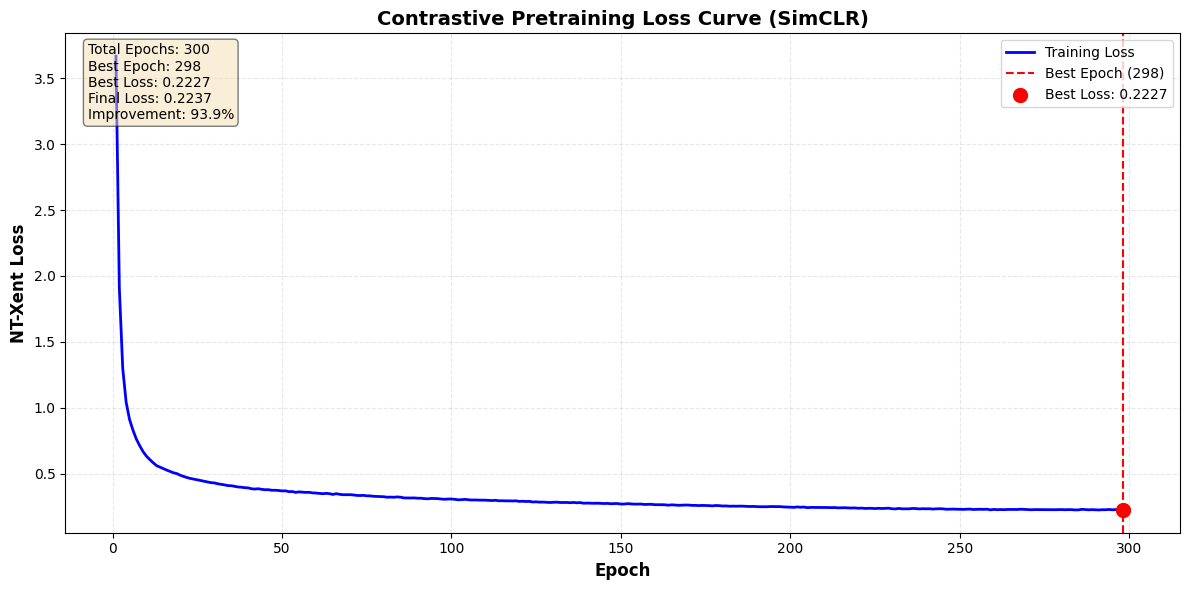

📊 TRAINING CURVE PLOTTED
✅ Loss decreased from 3.6697 to 0.2227
✅ Total improvement: 93.9%


In [15]:
import matplotlib.pyplot as plt

# Plot training loss curve
plt.figure(figsize=(12, 6))

# Plot loss
plt.plot(range(1, len(contrastive_losses) + 1), contrastive_losses, 
         'b-', linewidth=2, label='Training Loss')

# Mark best loss
best_epoch_idx = contrastive_losses.index(min(contrastive_losses))
plt.axvline(x=best_epoch_idx + 1, color='r', linestyle='--', 
            linewidth=1.5, label=f'Best Epoch ({best_epoch_idx + 1})')
plt.scatter([best_epoch_idx + 1], [best_contrastive_loss], 
            color='red', s=100, zorder=5, label=f'Best Loss: {best_contrastive_loss:.4f}')

# Formatting
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('NT-Xent Loss', fontsize=12, fontweight='bold')
plt.title('Contrastive Pretraining Loss Curve (SimCLR)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# Add statistics box
textstr = f'Total Epochs: {len(contrastive_losses)}\n'
textstr += f'Best Epoch: {best_epoch_idx + 1}\n'
textstr += f'Best Loss: {best_contrastive_loss:.4f}\n'
textstr += f'Final Loss: {contrastive_losses[-1]:.4f}\n'
textstr += f'Improvement: {((contrastive_losses[0] - best_contrastive_loss) / contrastive_losses[0] * 100):.1f}%'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=props)

plt.show()

print("="*80)
print("📊 TRAINING CURVE PLOTTED")
print("="*80)
print(f"✅ Loss decreased from {contrastive_losses[0]:.4f} to {best_contrastive_loss:.4f}")
print(f"✅ Total improvement: {((contrastive_losses[0] - best_contrastive_loss) / contrastive_losses[0] * 100):.1f}%")
print("="*80)

🎨 GENERATING UMAP VISUALIZATION OF PRETRAINED ENCODER
✅ UMAP already installed

📊 Extracting embeddings from pretrained encoder...


Extracting embeddings: 100%|██████████| 32/32 [00:02<00:00, 14.83it/s]
/home/RA001/Documents/OOD-MCD-GeoCV/env_ood/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Extracted embeddings shape: (2000, 256)

🔍 Performing UMAP dimensionality reduction...
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Sat Nov 29 09:54:01 2025 Construct fuzzy simplicial set
Sat Nov 29 09:54:03 2025 Finding Nearest Neighbors
Sat Nov 29 09:54:05 2025 Finished Nearest Neighbor Search
Sat Nov 29 09:54:06 2025 Construct embedding


Epochs completed:  10%| █          50/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs


Epochs completed:  38%| ███▊       189/500 [00:00]

	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs


Epochs completed:  65%| ██████▌    326/500 [00:00]

	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs


Epochs completed:  93%| █████████▎ 467/500 [00:01]

	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


Sat Nov 29 09:54:07 2025 Finished embedding
✅ UMAP embedding shape: (2000, 2)

🎨 Creating UMAP visualization...


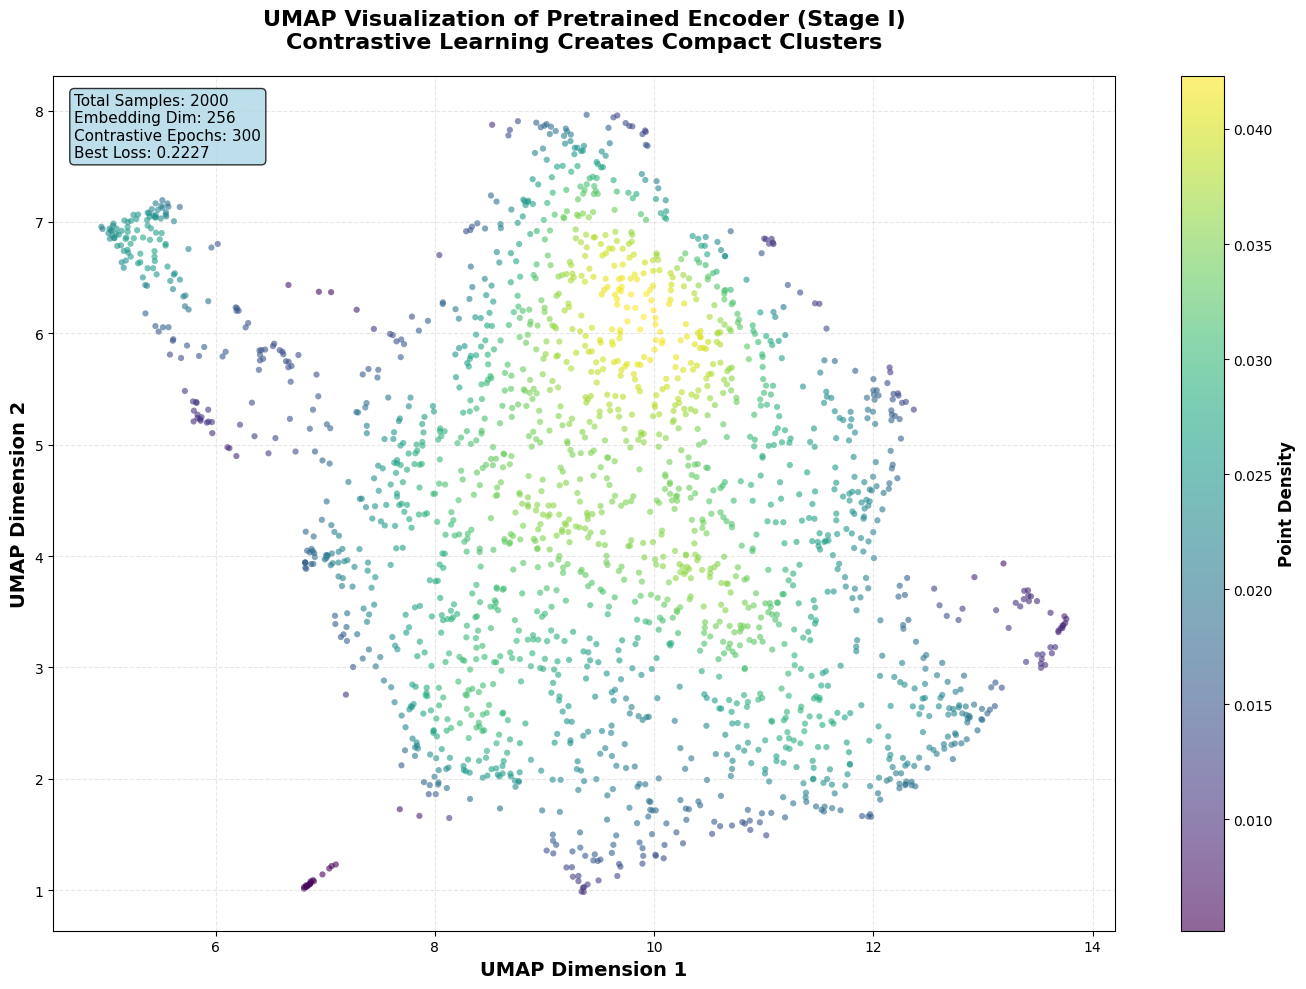


📊 UMAP VISUALIZATION COMPLETE
✅ Visualized 2000 samples in 2D space
✅ Original embedding dimension: 256
✅ Reduced to 2D using UMAP

💡 Key Observations:
   • Dense clusters indicate effective contrastive learning
   • Similar images (augmentations) should cluster together
   • Clear separation suggests good feature representation


In [16]:
# =============================================================================
# 🎯 UMAP Visualization of Pretrained Encoder (Stage I)
# =============================================================================
# This visualization shows the compact clusters learned through contrastive learning
# We'll extract embeddings from the pretrained encoder and visualize them in 2D

print("="*80)
print("🎨 GENERATING UMAP VISUALIZATION OF PRETRAINED ENCODER")
print("="*80)

# Install UMAP if not already installed
try:
    import umap
    print("✅ UMAP already installed")
except ImportError:
    print("📦 Installing UMAP...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'umap-learn'])
    import umap
    print("✅ UMAP installed successfully")

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

# Set the model to evaluation mode
contrastive_model.eval()

# ---------------------------------------------------------
# Extract embeddings from pretrained encoder
# ---------------------------------------------------------
print("\n📊 Extracting embeddings from pretrained encoder...")

# Use a subset of the contrastive dataset for visualization
num_samples = min(2000, len(contrastive_dataset))  # Sample 2000 images for visualization
sample_indices = np.random.choice(len(contrastive_dataset), num_samples, replace=False)
subset_dataset = Subset(contrastive_dataset, sample_indices)

# Create a DataLoader for the subset
viz_loader = DataLoader(subset_dataset, batch_size=64, shuffle=False, num_workers=2)

embeddings_list = []
with torch.no_grad():
    for batch in tqdm(viz_loader, desc="Extracting embeddings"):
        # Get the first augmentation from each batch
        if isinstance(batch, (list, tuple)):
            images = batch[0].to(device)
        else:
            images = batch.to(device)
        
        # Extract features from encoder
        features = contrastive_model.encoder(images)
        embeddings_list.append(features.cpu().numpy())

# Concatenate all embeddings
embeddings = np.vstack(embeddings_list)
print(f"✅ Extracted embeddings shape: {embeddings.shape}")

# ---------------------------------------------------------
# Perform UMAP dimensionality reduction
# ---------------------------------------------------------
print("\n🔍 Performing UMAP dimensionality reduction...")
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42,
    verbose=True
)

embedding_2d = reducer.fit_transform(embeddings)
print(f"✅ UMAP embedding shape: {embedding_2d.shape}")

# ---------------------------------------------------------
# Visualize the UMAP embeddings
# ---------------------------------------------------------
print("\n🎨 Creating UMAP visualization...")

fig, ax = plt.subplots(figsize=(14, 10))

# Create scatter plot with color based on density
from matplotlib.colors import LinearSegmentedColormap

# Calculate point density for coloring
from scipy.stats import gaussian_kde
xy = embedding_2d.T
z = gaussian_kde(xy)(xy)

# Sort points by density so densest points are plotted last
idx = z.argsort()
x, y, z = embedding_2d[idx, 0], embedding_2d[idx, 1], z[idx]

# Create scatter plot
scatter = ax.scatter(x, y, c=z, s=20, alpha=0.6, cmap='viridis', edgecolors='none')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Point Density', fontsize=12, fontweight='bold')

# Formatting
ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('UMAP Visualization of Pretrained Encoder (Stage I)\nContrastive Learning Creates Compact Clusters', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Add statistics box
textstr = f'Total Samples: {num_samples}\n'
textstr += f'Embedding Dim: {embeddings.shape[1]}\n'
textstr += f'Contrastive Epochs: {len(contrastive_losses)}\n'
textstr += f'Best Loss: {best_contrastive_loss:.4f}'

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Compute and display clustering metrics
# ---------------------------------------------------------
print("\n" + "="*80)
print("📊 UMAP VISUALIZATION COMPLETE")
print("="*80)
print(f"✅ Visualized {num_samples} samples in 2D space")
print(f"✅ Original embedding dimension: {embeddings.shape[1]}")
print(f"✅ Reduced to 2D using UMAP")
print("\n💡 Key Observations:")
print("   • Dense clusters indicate effective contrastive learning")
print("   • Similar images (augmentations) should cluster together")
print("   • Clear separation suggests good feature representation")
print("="*80)